# RFA Proyect 3
Training MLP models over Diabetic_Retinopathy dataset step 3
- Analysis on Reduce LR on Plateau to avoid overfit

## 3.0. Preprocess

In [ ]:
! pip install keras_tuner
! pip install datasets

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import keras
import keras_tuner

keras.utils.set_random_seed(23)
import tensorflow as tf
import numpy as np

!export TF_CUDNN_WORKSPACE_LIMIT_IN_MB=1024
from datasets import load_dataset, DatasetDict, ClassLabel

In [ ]:
def prepare_inputs(image_label):
    image = tf.cast(image_label["image"], tf.uint8)
    image = tf.image.resize(e["image"], [128, 128])
    image = tf.reshape(image, (-1,))
    return (image, tf.keras.utils.to_categorical(image_label["label"], num_classes=5))


ds = load_dataset("Rami/Diabetic_Retinopathy_Preprocessed_Dataset_256x256").shuffle(
    seed=23
)
ds = ds.cast_column(
    "label",
    ClassLabel(
        names=["Healthy", "Moderate DR", "Mild DR", "Proliferate DR", "Severe DR"]
    ),
)
ds = (
    ds["train"].to_tf_dataset().map(prepare_inputs, num_parallel_calls=tf.data.AUTOTUNE)
)
trainval, test = keras.utils.split_dataset(ds, right_size=0.20)
train, val = keras.utils.split_dataset(trainval, right_size=0.20)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
ds_train = train.cache()
ds_train = ds_train.shuffle(buffer_size=1000)
ds_train = ds_train.batch(128)
train_dataset = ds_train.prefetch(tf.data.AUTOTUNE)
ds_val = val.batch(128)
ds_val = ds_val.cache()
val_dataset = ds_val.prefetch(tf.data.AUTOTUNE)
ds_test = test.batch(128)
ds_test = ds_test.cache()
test_dataset = ds_test.prefetch(tf.data.AUTOTUNE)

In [ ]:
for e in train_dataset.take(1):
    print(f"After preprocesss Image type {type(e[0])}")
    print(f"After preprocesss Input shape: {e[0].shape}")
    input_dim = tuple(e[0].shape.as_list()[1:])
    num_classes = 5

After preprocesss Image type <class 'tensorflow.python.framework.ops.EagerTensor'>
After preprocesss Input shape: (128, 256, 256, 3)


## 3.1. Planificador: ReduceLROnPlateau

Resultados:
- Test: Accuracy 67.27% con factor=0.472, patienece=10
- Validation: Accuracy 64.77% con factor=0.472, patienece=10

In [ ]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        M = keras.Sequential()
        M.add(keras.Input(shape=input_dim))
        M.add(keras.layers.Dense(units=500, activation="relu"))
        M.add(keras.layers.Dense(num_classes, activation="softmax"))
        opt = keras.optimizers.Adam(learning_rate=0.0016787335100293622)
        M.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
        return M

    def fit(self, hp, M, train_dataset, val_dataset, **kwargs):
        factor = hp.Float("factor", min_value=0.1, max_value=0.5)
        patience = hp.Choice("patience", [2, 5, 10])
        reduce_cb = keras.callbacks.ReduceLROnPlateau(
            monitor="val_accuracy",
            factor=factor,
            patience=patience,
            min_delta=1e-4,
            min_lr=1e-5,
        )
        early_cb = keras.callbacks.EarlyStopping(
            monitor="val_accuracy", patience=2 * patience, min_delta=1e-5
        )
        kwargs["callbacks"].extend([reduce_cb, early_cb])
        return M.fit(
            train_dataset,
            batch_size=128,
            epochs=100,
            validation_data=val_dataset,
            **kwargs
        )

In [ ]:
tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective="val_accuracy",
    max_trials=10,
    overwrite=True,
    directory="/tmp",
    project_name="MNIST",
)

In [ ]:
tuner.search(train_dataset, val_dataset)

Trial 10 Complete [00h 01m 27s]
val_accuracy: 0.6454545259475708

Best val_accuracy So Far: 0.6477272510528564
Total elapsed time: 00h 10m 25s


In [ ]:
tuner.results_summary(num_trials=1)

Results summary
Results in /tmp/MNIST
Showing 1 best trials
Objective(name="val_accuracy", direction="max")

Trial 05 summary
Hyperparameters:
factor: 0.4729141152356867
patience: 10
Score: 0.6477272510528564


In [ ]:
best = tuner.get_best_models(num_models=1)[0]
score = best.evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}")

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Loss: 0.9486
Precisión: 66.91%


In [ ]:
opt = keras.optimizers.Adam(learning_rate=0.0016787335100293622)
best.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = best.fit(
    train_dataset.concatenate(val_dataset),
    batch_size=128,
    epochs=10,
    validation_data=val_dataset,
    verbose=0,
)
score = best.evaluate(test_dataset, verbose=0)
print(f"Loss: {score[0]:.4}\nPrecisión: {score[1]:.2%}")

Loss: 0.9624
Precisión: 67.27%


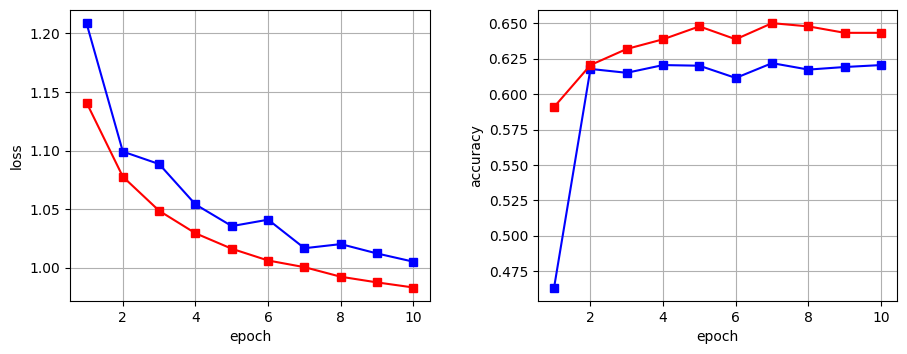

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(9, 3.5))
fig.tight_layout()
plt.subplots_adjust(wspace=0.3)
xx = np.arange(1, len(H.history["loss"]) + 1)
ax = axes[0]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.plot(xx, H.history["loss"], color="b", marker="s")
ax.plot(xx, H.history["val_loss"], color="r", marker="s")
ax = axes[1]
ax.grid()
ax.set_xlabel("epoch")
ax.set_ylabel("accuracy")
ax.plot(xx, H.history["accuracy"], color="b", marker="s")
ax.plot(xx, H.history["val_accuracy"], color="r", marker="s");